In [1]:
# Imports
from tmm_fast.vectorized_tmm_dispersive_multistack import coh_vec_tmm_disp_mstack
from numpy import pi, inf, array
import numpy as np
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm
import glob
from functools import partial


In [2]:
# Default plot parameters
font = {'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
legend_fs = 16

N = 5
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.gnuplot2(np.linspace(0,0.8,N)))
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['image.cmap'] = 'inferno'

### Material parameter imports and helper functions

In [3]:
def extract_nk(file_path, wavelength_unit='nm'):
    """ 
    Converts material parameter file (wavelength n k) into array and function used by the tmm module
    """
    mat_nk_temp = np.genfromtxt(file_path, skip_header=1)
    if wavelength_unit == 'nm': factor=1
    elif wavelength_unit == 'um': factor=1e3
    mat_nk_data = array([[factor*mat_nk_temp[x,0], (mat_nk_temp[x,1] + 1j*mat_nk_temp[x,2])] for x in range(len(mat_nk_temp))])
    mat_nk_fn = interp1d(mat_nk_data[:,0].real,
                          mat_nk_data[:,1], kind='quadratic')
    return mat_nk_data, mat_nk_fn


In [4]:
# Pure silicon 
n_Si = np.genfromtxt(r'Material_parameters\n_Si.txt', skip_header=1)    # real part 
k_Si = np.genfromtxt(r'Material_parameters\k_Si.txt', skip_header=1)    # imaginary part
N_Si = n_Si[:,1] + 1j*k_Si[:,1]                                         # complex refractive index
w_Si = 1e3*n_Si[:,0]                                                    # wavelengths (nm)

Si_nk_data = array([[w_Si[x], N_Si[x]] for x in range(len(w_Si))])              # tmm array
Si_nk_fn = interp1d(Si_nk_data[:,0].real, Si_nk_data[:,1], kind='quadratic')    # tmm function

# Import all available Si_{1-x}Ge_{x} material data
x_all = [2, 15, 35, 53]     # Ge concentrations

buffer_mat_data = []
for ii, x in enumerate(x_all):
    nk_path = r'Material_parameters\Si%iGe%i_jellison.txt' % ((100-x), x)
    nk_data, _ = extract_nk(nk_path, wavelength_unit='um')                                                                                  
    buffer_mat_data.append(nk_data)
buffer_mat_data = np.array(buffer_mat_data)

def Si1_xGe_x_nk(lam, x, buffer_mat_data, x_all=x_all):
    """ 
    Interpolator for nk data of SiGe alloys
    """
    w = buffer_mat_data[0,:,0]             # wavelengths
    nk_data = buffer_mat_data[:,:,1]       # refractive index
    interp = RegularGridInterpolator((x_all, w), nk_data,
                                 bounds_error=False, fill_value=None, method='linear')
    nk = interp((x, lam))
    return nk

# Constant composition spacer/buffer Si70Ge30 (interpolated)
SiGe_nk_fn = partial(Si1_xGe_x_nk, x=30, buffer_mat_data=buffer_mat_data)

# Native (passivating) silicon oxide 
natOx_nk_path = r'Material_parameters\SiOx_native.dat'
natOx_nk_data, natOx_nk_fn = extract_nk(natOx_nk_path)


In [5]:
def build_buffer(buffer_mat_data, 
                 remaining_t = float, 
                 total_t = float, 
                 num_grad_layers = int, 
                 lambda_list = array,
                 x_0 = 5.0, 
                 x_1 = 30.0):
    """
    Builds refractive index and thickness arrays corresponding to a (discretized) linearly graded Si_{1-x}Ge_{x} buffer
    that has (possibly) been etched into by TMAH.

    Arguments: 
        mat_data :      list of Nx3 arrays ([[wavelengths],[n],[k]]) of available set of Si_{1-x}Ge_{x} material data
        remaining_t :   total initial buffer thickness - etched buffer thickness (nm)
        total_t :       total initial buffer thickness (nm)
        num_grad_layers :    step size of the buffer discretization into layers 
        lambda_list :   list of wavelengths (nm)
        x_0 :           starting Ge concentration (%)
        x_1 :           maximum Ge concentration before etching (%)

    Returns: 
        buffer_nk :     list of complex refractive indices for each discretized step
        d_layer :       discretized thickness slices (nm)
    """

    x_list = np.linspace(x_1, x_0, num_grad_layers)            # Ge concentration of discretized layers
    d_layer = total_t / num_grad_layers                        # thickness of a discretized layer
    num_whole_layers = int(remaining_t // d_layer)             # number of full d_layer-thick layers 
    layer_remainder = np.remainder(remaining_t, d_layer)       # remaining layer with thickness < d_layer 
    if remaining_t==0:
        d_list = [0]
    elif np.mod(remaining_t, d_layer) != 0:
        d_list = [d_layer]*num_whole_layers + [layer_remainder]
    else: 
        d_list = [d_layer]*num_whole_layers
    
    # Interpolator for arbitrary Ge concentrations and wavelengths
    buffer_nk = []
    for ii in range(len(d_list)):
        buffer_nk.append(
            Si1_xGe_x_nk(lambda_list, x_list[ii], buffer_mat_data)
        )
        
    buffer_nk = array(buffer_nk)
    return buffer_nk, d_list

def build_n_tables(lambda_master):
    # Each function returns complex n + 1j*k for vector inputs
    n_natox = natOx_nk_fn(lambda_master)
    n_si    = Si_nk_fn(lambda_master)
    n_sige  = SiGe_nk_fn(lambda_master)
    return n_natox, n_si, n_sige

### Custom curve fit function

In [6]:
degree = np.pi / 180.0

def ellips_model_cf(lam,            # wavelengths (single vector, not concatenated)
                    ox_front, si_cap, sige_spacer, si_qw, constant_buffer,
                    graded_buffer, ox_back,        # fit parameters 
                    *,
                    thetas_deg=(50,55,60,65,70),   # incident angles
                    total_t=2500,                  # graded buffer thickness before etching
                    num_grad_layers=50,            # number of discretized layers (before etching)
                    device='cpu',
                    nk_funcs=None,                 # dict of vectorized nk functions
                    output_fmt='ellipsometric'     # ellipsometric or complex
                    ):
    """
    Returns a 1D array: [psi(theta, lambda), delta(theta, lambda), psi(...), delta(...), ...]
    """

    natOx_nk_fn = nk_funcs['natox']
    Si_nk_fn    = nk_funcs['si']
    SiGe_nk_fn  = nk_funcs['sige']
    air_nk_fn   = nk_funcs.get('air', lambda lam: np.ones_like(lam, dtype=complex))
    
    # Refractive index stack N with shape [S=1, L, W] 
    n_layers = []
    n_layers.append(air_nk_fn(lam))          # ambient (semi-inf)
    n_layers.append(natOx_nk_fn(lam))        # ox_front
    n_layers.append(Si_nk_fn(lam))           # si_cap
    n_layers.append(SiGe_nk_fn(lam))         # sige_spacer
    n_layers.append(Si_nk_fn(lam))           # si_qw
    n_layers.append(SiGe_nk_fn(lam))         # constant_buffer

    buffer_nk, d_list_buffer = build_buffer(
        buffer_mat_data, remaining_t=graded_buffer, total_t=total_t, num_grad_layers=num_grad_layers, lambda_list=lam
    )
    buffer_nk = np.array(buffer_nk)
    for jj in range(len(d_list_buffer)):
        n_layers.extend(buffer_nk[jj,:][np.newaxis, :])

    n_layers.append(natOx_nk_fn(lam))        # ox_back
    n_layers.append(air_nk_fn(lam))          # ambient (semi-inf)

    # Thickness list (nm)  
    d_fixed = np.array([ox_front, si_cap, sige_spacer, si_qw, constant_buffer], dtype=float)
    d_list = np.concatenate(([np.inf], d_fixed, d_list_buffer, [ox_back, np.inf]))
    L = d_list.size

    N_LW = np.stack(n_layers, axis=0)        # [L, W]
    N = N_LW[np.newaxis, ...]                # [1, L, W]  
    T = d_list[np.newaxis, :]                # [1, L]

    # Vectorized coherent TMM for s and p
    thetas_rad = np.array([angle * degree for angle in thetas_deg])  # Angles in rad
    res_s = coh_vec_tmm_disp_mstack(pol='s', N=N, T=T, Theta=thetas_rad, lambda_vacuum=lam, device=device)
    res_p = coh_vec_tmm_disp_mstack(pol='p', N=N, T=T, Theta=thetas_rad, lambda_vacuum=lam, device=device)

    # r has shape [S=1, A, W] -> take [0, :, :]
    r_s = np.asarray(res_s['r'])[0, :, :]   # shape [A, W]
    r_p = np.asarray(res_p['r'])[0, :, :]   # shape [A, W]

    rho = r_p / r_s                         # shape [A, W]

    if output_fmt == 'ellipsometric':
        psi_deg   = np.degrees(np.arctan(np.abs(rho)))                    
        # Unwrap phase 
        delta_deg = 360.0 - (np.degrees(np.unwrap(np.angle(rho), axis=1)) % 360.0)  

        # Match output to data shape
        out_arr = np.concatenate([psi_deg, delta_deg], axis=1).ravel()    # length A*(2W)

    elif output_fmt == 'complex':
        rho_real = rho.real                                               # [A, W]
        rho_imag = rho.imag                                               # [A, W]
        # Match output to data shape
        out_arr = np.concatenate([rho_real, rho_imag], axis=1).ravel()    # length A*(2W)

    return out_arr



### Wafer A

In [7]:
folder_path = r"Raw_data\\ellipsometry_waferA\\"
base_filename = r"CMP1_RCE6-p0"
file_pattern = folder_path + base_filename + "[1-9]-vase_20240823-??????.ds.dat"
files = glob.glob(file_pattern)
files.sort()

waferA_data = []
for filename in files:
    waferA_data.append(
        np.genfromtxt(filename, delimiter='\t', encoding='unicode_escape')
    )

In [8]:
total_t = 2500
num_grad_layers = 50

popt_listA = []
pcov_listA = []
for jj, temp in enumerate(tqdm(waferA_data)):
    xdata = []
    ydata = []
    if jj == 7: thetas = np.array([50,55,60,70])        # this data set is missing data for 65 degrees
    else: thetas = np.arange(50,75,5)
    for t, theta in enumerate(thetas):
        arg = waferA_data[jj][:,1] == theta
        # Concatenate wavelength vectors (not all angle datasets have the same length after NaN masking)
        xdata = np.concatenate([xdata, waferA_data[jj][arg, 2], waferA_data[jj][arg, 2]])   
        # Concatenate [[psi, delta], [psi, delta], ...]
        ydata = np.concatenate([ydata, waferA_data[jj][arg, 8], waferA_data[jj][arg, 7]])
    arg = np.where(xdata<820)       # Material data only goes until 820 nm 
    xdata = xdata[arg]
    ydata = ydata[arg]
    mask = np.isfinite(ydata)       # Mask NaNs
    idx  = np.flatnonzero(mask)
    xfit = xdata[mask]
    yfit = ydata[mask]

    # Vectorized nk functions 
    nk_funcs = dict(
        air   = lambda lam: np.ones_like(lam, dtype=complex),
        natox = natOx_nk_fn,   
        si    = Si_nk_fn,
        sige  = SiGe_nk_fn,
        substrate = lambda lam: np.ones_like(lam, dtype=complex)  
    )
    
    # Wrapper to fix graded buffer thickness to 0 for Wafer A (possible to estimate from data inspection)
    def model_for_fit(lam_full, *p):
        lam = np.split(lam_full, 2*len(thetas))[0]
        ox_front, si_cap, sige_spacer, si_qw, constant_buffer, ox_back = p 
        y_pred_full = ellips_model_cf(lam,
                        ox_front=ox_front, 
                        si_cap=si_cap,
                        sige_spacer=sige_spacer,  
                        si_qw=si_qw, 
                        constant_buffer=constant_buffer, 
                        graded_buffer=0.0, 
                        ox_back=ox_back,
                        thetas_deg=thetas,     
                        total_t=total_t,
                        num_grad_layers=num_grad_layers,
                        device='cpu',
                        nk_funcs=nk_funcs, 
                        output_fmt='ellipsometric')
        return y_pred_full[idx]

    # Starting parameters & bounds 
    p0     = [2,2,30,10,2400,2]  # ox_front, si_cap, sige_spacer, si_qw, graded_buffer, ox_back
    lower  = [0,0,25,1,2300,0]
    upper  = [10,3,35,15,2500,4]

    # Fit
    popt, pcov = curve_fit(model_for_fit, xdata, yfit, p0=p0, bounds=(lower, upper), maxfev=5000)
    
    # Store data
    popt_listA.append(popt)
    pcov_listA.append(pcov)

  0%|          | 0/9 [00:00<?, ?it/s]

c:\Users\lucas\miniforge3\envs\ellipsometry\Lib\site-packages\scipy\interpolate\_rgi.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  p = np.asarray(p, dtype=float)
c:\Users\lucas\miniforge3\envs\ellipsometry\Lib\site-packages\tmm_fast\vectorized_tmm_dispersive_multistack.py:152: UserWarning: Opacity warning. The imaginary part of the refractive index is clamped to 35i for numerical stability.
You might encounter problems with gradient computation...
  warn('Opacity warning. The imaginary part of the refractive index is clamped to 35i for numerical stability.\n'+


In [236]:
# Export results (wafer A)
perr_listA = [np.sqrt(np.diag(x)) for x in pcov_listA]

np.savetxt('membraneA_thickness.txt', popt_listA)
np.savetxt('membraneA_thickness_error.txt', perr_listA)


<>:42: SyntaxWarning: invalid escape sequence '\c'
<>:51: SyntaxWarning: invalid escape sequence '\D'
<>:52: SyntaxWarning: invalid escape sequence '\P'
<>:42: SyntaxWarning: invalid escape sequence '\c'
<>:51: SyntaxWarning: invalid escape sequence '\D'
<>:52: SyntaxWarning: invalid escape sequence '\P'
C:\Users\lucas\AppData\Local\Temp\ipykernel_28196\1802965979.py:42: SyntaxWarning: invalid escape sequence '\c'
  if jj == len(waferA_data)-1 : label='%i$^\circ$'%thetas[ii]
C:\Users\lucas\AppData\Local\Temp\ipykernel_28196\1802965979.py:51: SyntaxWarning: invalid escape sequence '\D'
  ax[jj,1].set_ylabel('$\Delta$ (deg)')
C:\Users\lucas\AppData\Local\Temp\ipykernel_28196\1802965979.py:52: SyntaxWarning: invalid escape sequence '\P'
  ax[jj,0].set_ylabel('$\Psi$ (deg)')
c:\Users\lucas\miniforge3\envs\ellipsometry\Lib\site-packages\scipy\interpolate\_rgi.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  p = np.asarray(p, dtype=float)
c:\Users\lucas\min

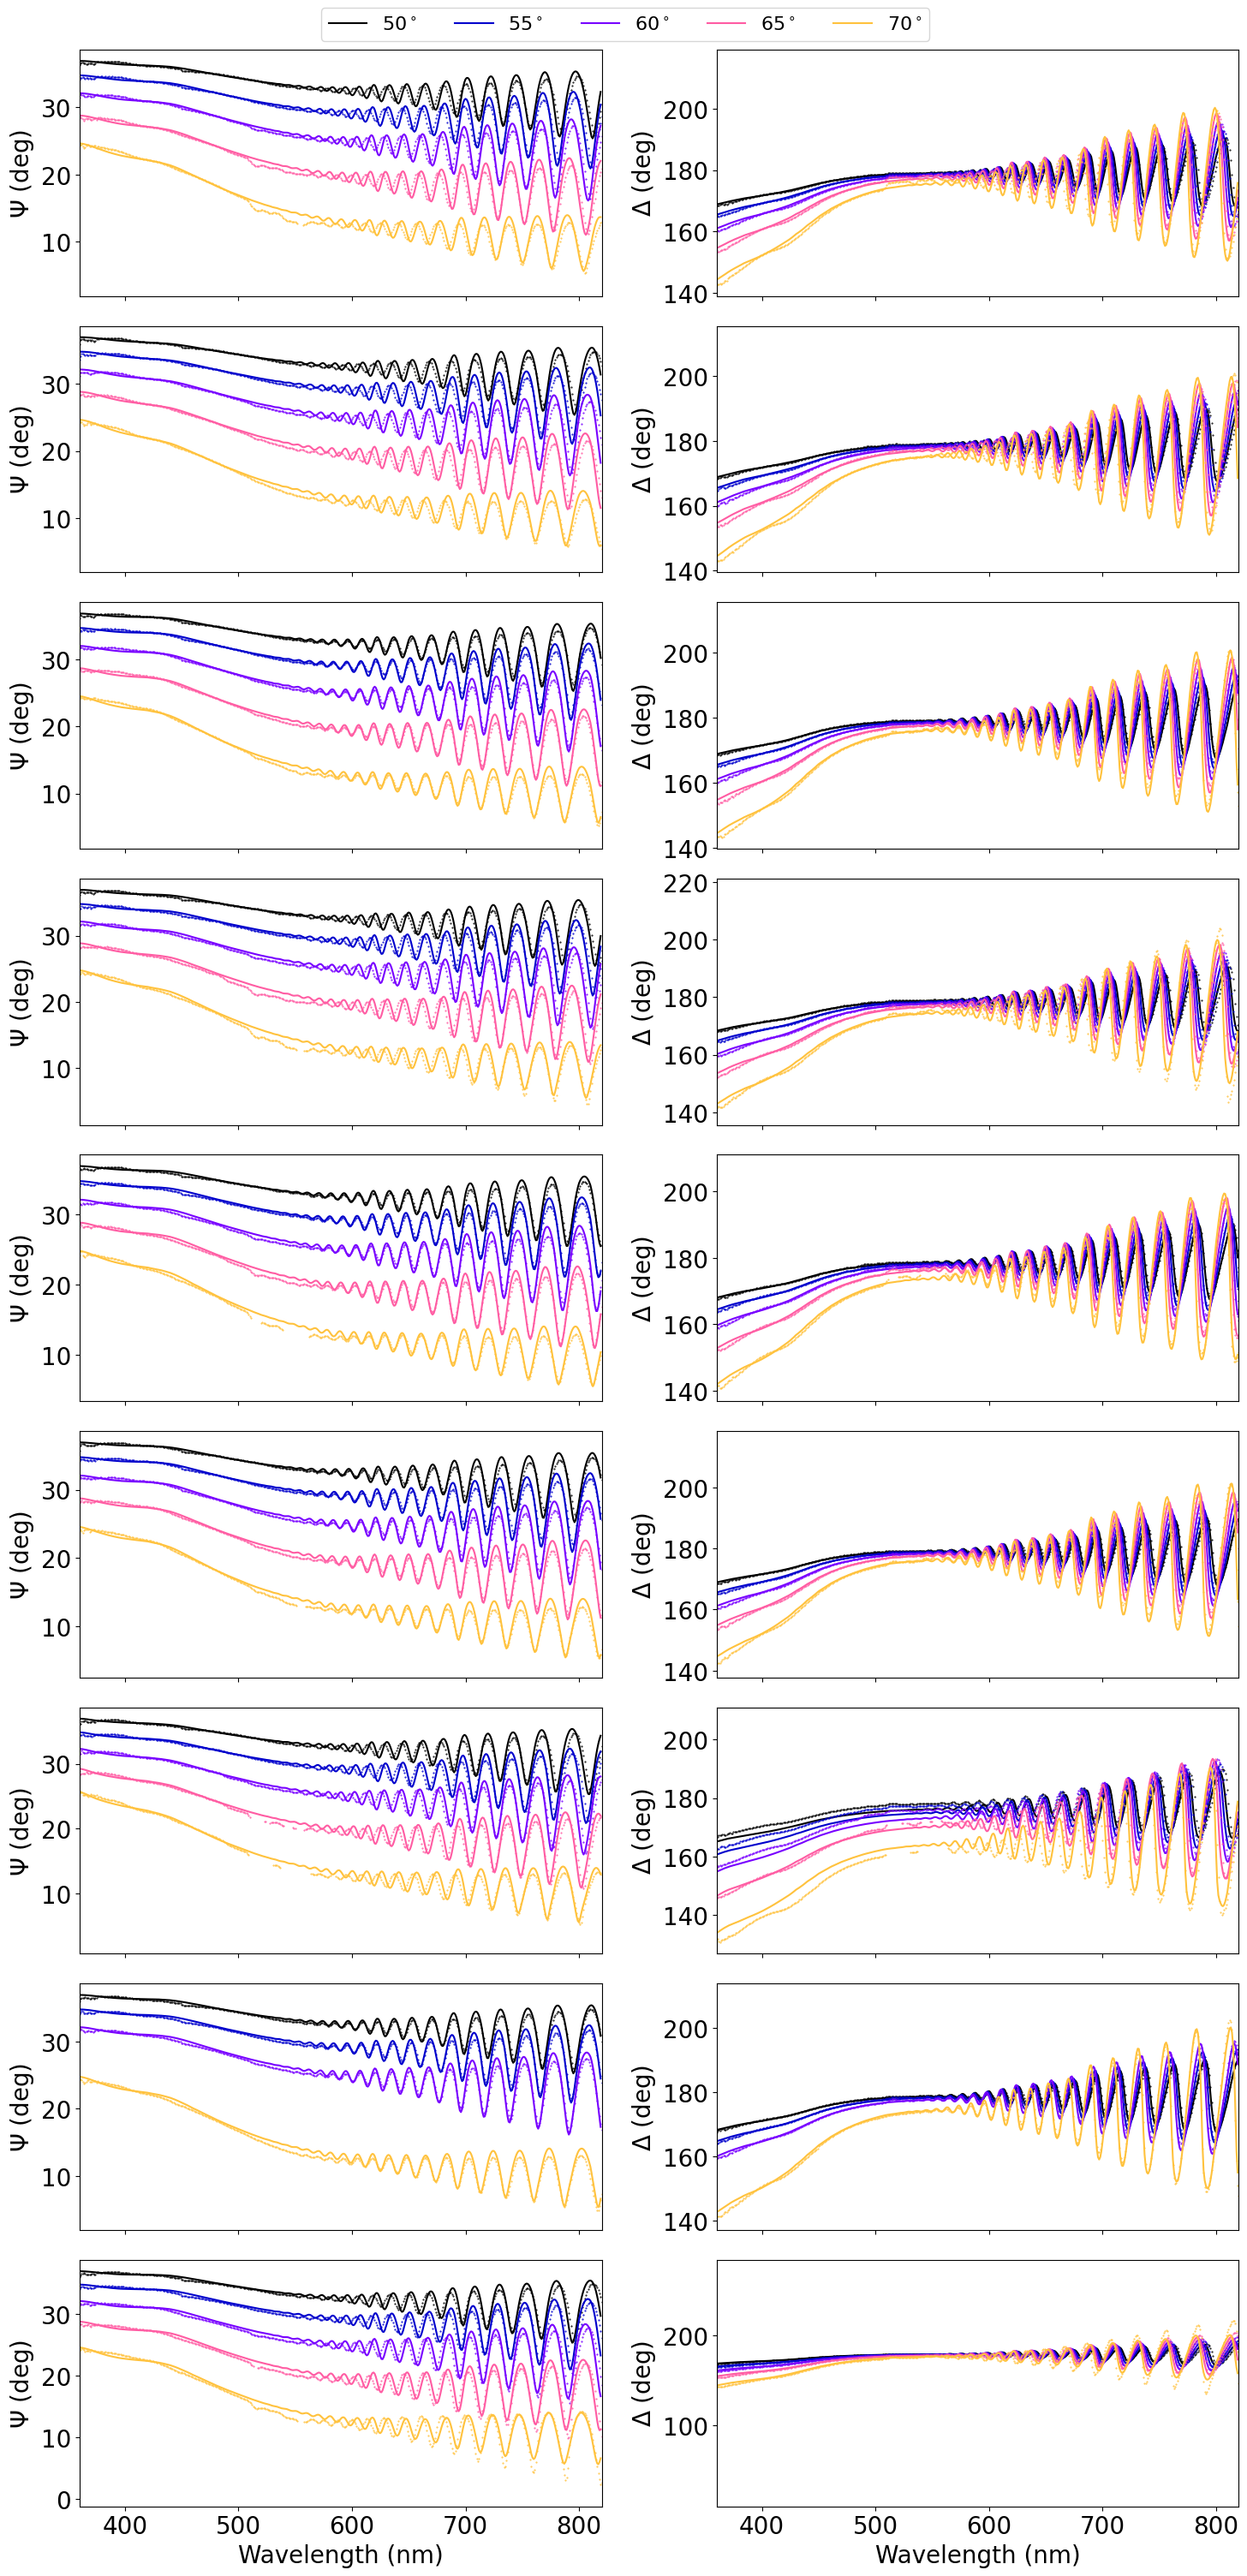

In [ ]:
# Plot results
fig, ax = plt.subplots(9,2, figsize=(15,30), sharex=True)

jump_factor = int(len(xdata)/len(thetas))
xdata_concat = xdata

# Model for plotting (each angle is plotted sequentially)
def model(lam, ox_front, si_cap, sige_spacer, si_qw, constant_buffer, ox_back, thetas_deg):
       result = ellips_model_cf(lam,
                        ox_front=ox_front, 
                        si_cap=si_cap,
                        sige_spacer=sige_spacer,  
                        si_qw=si_qw, 
                        constant_buffer=constant_buffer, 
                        graded_buffer=0.0, 
                        ox_back=ox_back,
                        thetas_deg=thetas_deg,     
                        total_t=total_t,
                        num_grad_layers=num_grad_layers,
                        device='cpu',
                        nk_funcs=nk_funcs, 
                        output_fmt='ellipsometric')
       return result 

for jj, data in enumerate(waferA_data):
       for ii, theta in enumerate(thetas):
              arg = waferA_data[jj][:,1] == theta
              w_data = waferA_data[jj][arg, 2]
              psi_data = waferA_data[jj][arg, 8]
              delta_data = waferA_data[jj][arg, 7]
              x_fit = w_data[np.where(w_data < 820)]
              y_fit = model(x_fit, *popt_listA[jj], thetas_deg=[theta])
              psi_fit, delta_fit = np.array_split(y_fit,2)
              color = color_cycle[ii]
              cut = 5                     # Disjoin concatenated data to achieve different colors for each angle
              if jj == len(waferA_data)-1 : label='%i$^\circ$'%thetas[ii]
              else: label = None
              ax[jj,0].plot(w_data, psi_data, 
                            'o', markersize=0.5, color=color, mfc=None, label=None)
              ax[jj,0].plot(x_fit, psi_fit, color=color, label=None)
              ax[jj,1].plot(w_data, delta_data, 
                            'o', markersize=0.5, color=color, mfc=None, label=None)
              ax[jj,1].plot(x_fit, delta_fit, color=color, label=label)

       ax[jj,1].set_ylabel('$\Delta$ (deg)')
       ax[jj,0].set_ylabel('$\Psi$ (deg)')
       ax[jj,0].set_xlim([360,820])
       ax[jj,1].set_xlim([360,820])

ax[len(waferA_data)-1,0].set_xlabel('Wavelength (nm)')
ax[len(waferA_data)-1,1].set_xlabel('Wavelength (nm)')
fig.legend(loc='upper center', ncols=5, fontsize=legend_fs, bbox_to_anchor=(0.5, 1.01))
fig.tight_layout()

### Wafer B

In [11]:
folder_path = r"Raw_data\\ellipsometry_waferB\\"
base_filename = r"muMem1-RCE6-Vase-p0"
file_pattern = folder_path + base_filename + "[1-9]_20240827-??????.ds.dat"
files = glob.glob(file_pattern)
files.sort()

waferB_data = []
for filename in files:
    waferB_data.append(
        np.genfromtxt(filename, delimiter='\t', encoding='unicode_escape')
    )

In [12]:
total_t = 3750
num_grad_layers = 300
thetas = np.arange(50,75,5)

# Different starting points for graded buffer thicknesses obtained from data inspection
p0_buffer = np.array([100, 710, 390, 220, 710, 660, 640, 690]) 

popt_listB = []
pcov_listB = []
for jj, temp in enumerate(tqdm(waferB_data)):
    if jj==0: continue
    xdata = []
    ydata = []
    for t, theta in enumerate(thetas):
        arg = waferB_data[jj][:,1] == theta
        xdata = np.concatenate([xdata, waferB_data[jj][arg, 2], waferB_data[jj][arg, 2]])
        ydata = np.concatenate([ydata, waferB_data[jj][arg, 8], waferB_data[jj][arg, 7]])
    arg = np.where(xdata<820)
    xdata = xdata[arg]
    ydata = ydata[arg]
    mask = np.isfinite(ydata)
    idx  = np.flatnonzero(mask)
    xfit = xdata[mask]
    yfit = ydata[mask]

    # Vectorized nk functions
    nk_funcs = dict(
        air   = lambda lam: np.ones_like(lam, dtype=complex),
        natox = natOx_nk_fn,   
        si    = Si_nk_fn,
        sige  = SiGe_nk_fn,
        substrate = lambda lam: np.ones_like(lam, dtype=complex) 
    )
    
    # Wrap model to pin fixed args (curve_fit only passes x and *params)
    def model_for_fit(lam_full, *p):
        lam = np.split(lam_full, 2*len(thetas))[0]
        model = partial(ellips_model_cf,
                        thetas_deg=thetas,     
                        total_t=total_t,
                        num_grad_layers=num_grad_layers,
                        device='cpu',
                        nk_funcs=nk_funcs, 
                        output_fmt='ellipsometric')
        y_pred_full = model(lam, *p)
        return y_pred_full[idx]
       
    p0     = [3, 1e-3, 45, 10, 600, p0_buffer[jj-1], 2]  # ox_front, si_cap, sige_spacer, si_qw, constant_buffer, graded_buffer, ox_back
    lower  = [0, 0, 20, 0, 590, p0_buffer[jj-1]-200, 0]
    upper  = [10, 2, 70, 15, 610, p0_buffer[jj-1]+200, 5]

    # Fit
    popt, pcov = curve_fit(model_for_fit, xdata, yfit, p0=p0, bounds=(lower, upper), maxfev=5000)

    popt_listB.append(popt)
    pcov_listB.append(pcov)

  0%|          | 0/9 [00:00<?, ?it/s]

In [222]:
# Export results (wafer B)
perr_listB = [np.sqrt(np.diag(x)) for x in pcov_listB]

np.savetxt('membraneB_thickness.txt', popt_listB)
np.savetxt('membraneB_thickness_error.txt', perr_listB)

<>:34: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\D'
<>:38: SyntaxWarning: invalid escape sequence '\P'
<>:34: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\D'
<>:38: SyntaxWarning: invalid escape sequence '\P'
C:\Users\lucas\AppData\Local\Temp\ipykernel_28196\3940197707.py:34: SyntaxWarning: invalid escape sequence '\c'
  if jj == len(waferB_data)-1 : label='%i$^\circ$'%thetas[ii]
C:\Users\lucas\AppData\Local\Temp\ipykernel_28196\3940197707.py:37: SyntaxWarning: invalid escape sequence '\D'
  ax[jj,1].set_ylabel('$\Delta$ (deg)')
C:\Users\lucas\AppData\Local\Temp\ipykernel_28196\3940197707.py:38: SyntaxWarning: invalid escape sequence '\P'
  ax[jj,0].set_ylabel('$\Psi$ (deg)')


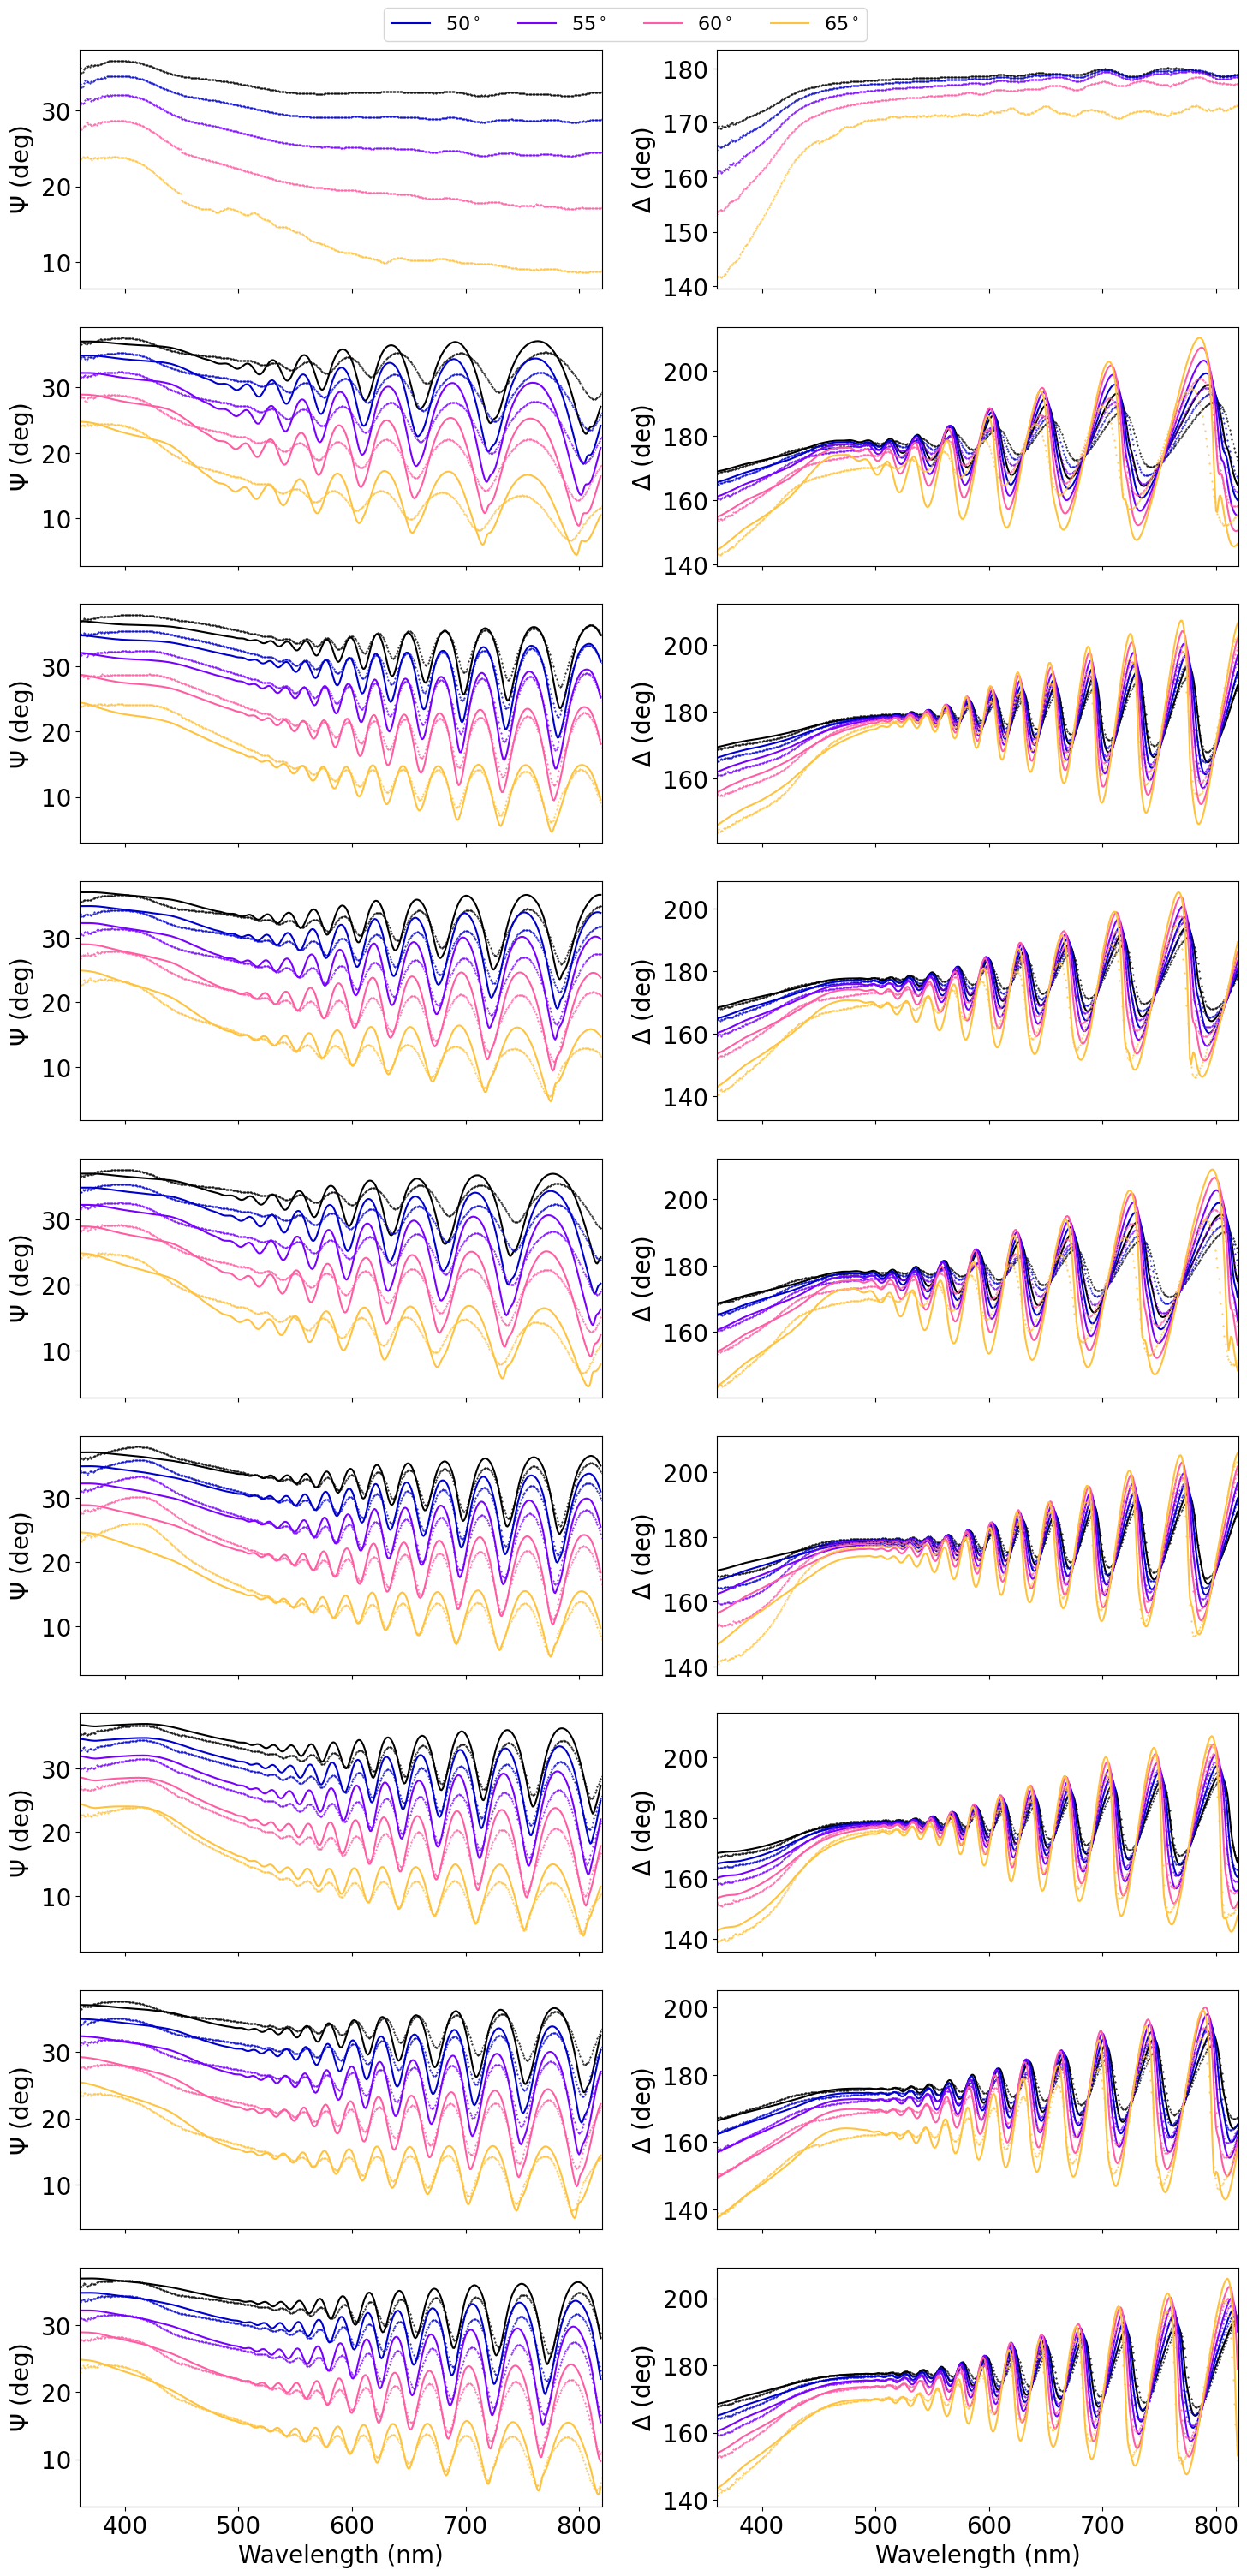

In [ ]:
# Plot results
fig, ax = plt.subplots(9,2, figsize=(15,30), sharex=True)

jump_factor = int(len(xdata)/len(thetas))
xdata_concat = xdata
cut = 5

model = partial(ellips_model_cf,
                    thetas_deg=thetas,     
                    total_t=total_t,
                    num_grad_layers=num_grad_layers,
                    device='cpu',
                    nk_funcs=nk_funcs)

for jj, data in enumerate(waferB_data):
       for ii, theta in enumerate(thetas):
              arg = waferB_data[jj][:,1] == theta
              w_data = waferB_data[jj][arg, 2]
              psi_data = waferB_data[jj][arg, 8]
              delta_data = waferB_data[jj][arg, 7]
              color = color_cycle[ii]
              ax[jj,0].plot(w_data, psi_data, 
                            'o', markersize=0.5, color=color, mfc=None, label=None)
              ax[jj,1].plot(w_data, delta_data, 
                            'o', markersize=0.5, color=color, mfc=None, label=None)
              if jj != 0:          # Skip fit of first data set (no oscillations -> second buckling mode presumably leads to strong incoherent effects)
                     x_fit = w_data[np.where(w_data < 820)]
                     y_fit = model(x_fit, *popt_listB[jj-1], thetas_deg=[theta])
                     psi_fit, delta_fit = np.array_split(y_fit,2)
                     
                     ax[jj,0].plot(x_fit, psi_fit, color=color, label=None)
                     
                     ax[jj,1].plot(x_fit, delta_fit, color=color, label=label)
              if jj == len(waferB_data)-1 : label='%i$^\circ$'%thetas[ii]
              else: label = None

       ax[jj,1].set_ylabel('$\Delta$ (deg)')
       ax[jj,0].set_ylabel('$\Psi$ (deg)')
       ax[jj,0].set_xlim([360,820])
       ax[jj,1].set_xlim([360,820])

ax[len(waferB_data)-1,0].set_xlabel('Wavelength (nm)')
ax[len(waferB_data)-1,1].set_xlabel('Wavelength (nm)')
fig.legend(loc='upper center', ncols=5, fontsize=legend_fs, bbox_to_anchor=(0.5, 1.01))
fig.tight_layout()

### Exemplary plots for appendix

<>:49: SyntaxWarning: invalid escape sequence '\c'
<>:67: SyntaxWarning: invalid escape sequence '\D'
<>:68: SyntaxWarning: invalid escape sequence '\P'
<>:49: SyntaxWarning: invalid escape sequence '\c'
<>:67: SyntaxWarning: invalid escape sequence '\D'
<>:68: SyntaxWarning: invalid escape sequence '\P'
C:\Users\lucas\AppData\Local\Temp\ipykernel_1520\2289252034.py:49: SyntaxWarning: invalid escape sequence '\c'
  if kk == len(data_arr)-1 : label='%i$^\circ$'%thetas[ii]
C:\Users\lucas\AppData\Local\Temp\ipykernel_1520\2289252034.py:67: SyntaxWarning: invalid escape sequence '\D'
  ax[0,0].set_ylabel('$\Delta$ (deg)')
C:\Users\lucas\AppData\Local\Temp\ipykernel_1520\2289252034.py:68: SyntaxWarning: invalid escape sequence '\P'
  ax[1,0].set_ylabel('$\Psi$ (deg)')
c:\Users\lucas\miniforge3\envs\ellipsometry\Lib\site-packages\scipy\interpolate\_rgi.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  p = np.asarray(p, dtype=float)
c:\Users\lucas\miniforge3\

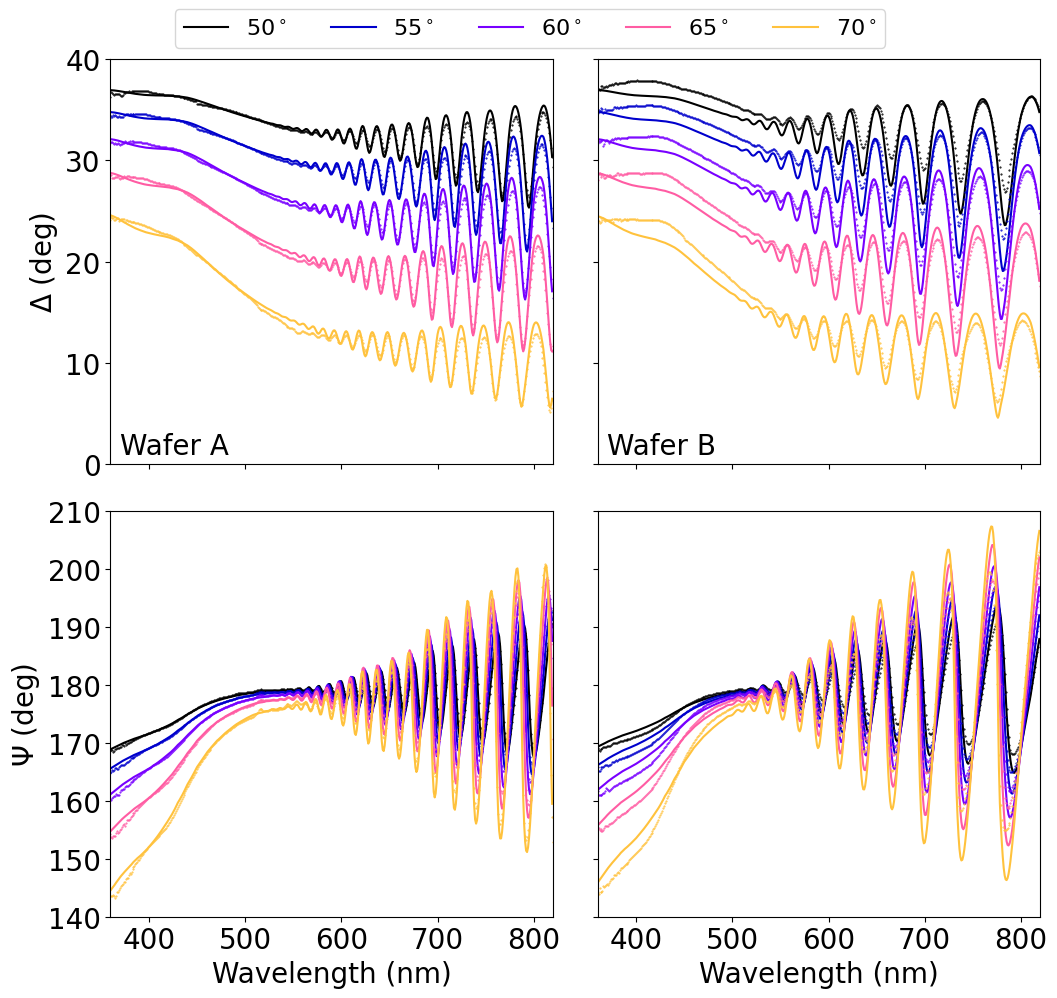

In [ ]:
# Plot results
fig, ax = plt.subplots(2,2, figsize=(11,10), sharex=True)

jump_factor = int(len(xdata)/len(thetas))
xdata_concat = xdata

# Model for plotting (each angle is plotted sequentially)
def model_A(lam, ox_front, si_cap, sige_spacer, si_qw, constant_buffer, ox_back, thetas_deg):
       result = ellips_model_cf(lam,
                        ox_front=ox_front, 
                        si_cap=si_cap,
                        sige_spacer=sige_spacer,  
                        si_qw=si_qw, 
                        constant_buffer=constant_buffer, 
                        graded_buffer=0.0, 
                        ox_back=ox_back,
                        thetas_deg=thetas_deg,     
                        total_t=2500,
                        num_grad_layers=num_grad_layers,
                        device='cpu',
                        nk_funcs=nk_funcs, 
                        output_fmt='ellipsometric')
       return result 

model_B = partial(ellips_model_cf,
                    thetas_deg=thetas,     
                    total_t=3750,
                    num_grad_layers=num_grad_layers,
                    device='cpu',
                    nk_funcs=nk_funcs)

data_arr = [waferA_data, waferB_data]
popt_arr = [popt_listA, popt_listB]
model_arr = [model_A, model_B]
jj=2    # Membrane index
for kk, data in enumerate(data_arr):
        for ii, theta in enumerate(thetas):
                arg = data[jj][:,1] == theta
                w_data = data[jj][arg, 2]
                psi_data = data[jj][arg, 8]
                delta_data = data[jj][arg, 7]
                x_fit = w_data[np.where(w_data < 820)]
                if kk==0: idx = jj
                elif kk==1: idx = jj-1
                y_fit = model_arr[kk](x_fit, *popt_arr[kk][idx], thetas_deg=[theta])
                psi_fit, delta_fit = np.array_split(y_fit,2)
                color = color_cycle[ii]
                cut = 5                     # Disjoin concatenated data to achieve different colors for each angle
                if kk == len(data_arr)-1 : label='%i$^\circ$'%thetas[ii]
                else: label = None
                ax[0,kk].plot(w_data, psi_data, 
                        'o', markersize=0.5, color=color, mfc=None, label=None)
                ax[0,kk].plot(x_fit, psi_fit, color=color, label=None)
                ax[1,kk].plot(w_data, delta_data, 
                        'o', markersize=0.5, color=color, mfc=None, label=None)
                ax[1,kk].plot(x_fit, delta_fit, color=color, label=label)

        ax[0,kk].set_xlim([360,820])
        ax[1,kk].set_xlim([360,820])
        ax[0,kk].set_ylim([0,40])
        ax[1,kk].set_ylim([140,210])

ax[0,0].text(x=370, y=1, s="Wafer A")
ax[0,1].text(x=370, y=1, s="Wafer B")
ax[0,1].set(yticklabels=[])
ax[1,1].set(yticklabels=[])
ax[0,0].set_ylabel('$\Delta$ (deg)')
ax[1,0].set_ylabel('$\Psi$ (deg)')
ax[1,0].set_xlabel('Wavelength (nm)')
ax[1,1].set_xlabel('Wavelength (nm)')
fig.legend(loc='upper center', ncols=5, fontsize=legend_fs, bbox_to_anchor=(0.5, 1.02))
fig.tight_layout()

plt.savefig('Fig10.pdf', format='pdf', dpi=300)